## A/B - тестирование


Внутри увидите пример как формируются результаты по аб-тестированию. Прочтите сначала его, затем приступайте к выполнению задания.

В папке присутствует файл ab_test_ensembles.csv , который содержит реальные данные ab теста, когда-то проходившего у меня. Вам необходимо провести стандартный пайплайн, начав с ознакомления данных до вывода отчета. Условие гипотезы такое же как и в примере, нам необходимо нашим новым вариантом увеличить коэффициент конверсии на 2%, коэффициенты конверсии одинаковы с файлом из примера (плюс/минус) поэтому с этим проблем быть не должно. Условия гипотез теже.

В A/B тесте было два варианта работы сервиса - standard и svm_ensemble_v_1_22, где работала модель классификации пользователей.

Ответьте на 2 вопроса:

1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22 (используем всю выборку 200к+ записей)
2. Так же посчитайте вывод для типа пользователей (user_type) стоит ли для новых/старых пользователей (new/registered user) оставить старый / новый вариант работы (разделяем всю выборку 200к+ записей на группы)

Также необходимо провести небольшое EDA по представленному датасету, нарисовать два графика на ваш вкус.

---

**Баллы могут быть снижены** за качество кода - старайтесь чтобы код был максимально лаконичным. Названия переменных (если они используются) должны отражать максимальную ее сущность.

**Комментарии по сдаче практического задания**:
1. Залить в репу на github в папку module_2/ab_test_inference
2. Ссылку на репо отправлять мне на почту alexadevv@gmail.com не позднее дедлайна.
3. Тема письма: Домашнее задание по модулю 2 <Фамилия Имя>
4. После дедлайна, неотправленные на почту задания, оцениваются максимум в 7 баллов.

# Решение задания 1. Стоит ли нам оставить старый вариант работы или заменить на вариант svm_ensemble_v_1_22?

Загружаем необходимые библиотеки и задаем параметры визуализации в библиотеке Seaborn, после чего загружаем датасет

In [446]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [447]:
plt.style.use('seaborn-v0_8-whitegrid')
font = {'family' : 'Arial',
        'weight' : 'bold',
        'size'   : 14}
mpl.rc('font', **font)

In [448]:
df = pd.read_csv('ab_test_ensembles.csv')
df.head()

,user_id,timestamp,group,variants,converted,location,age_group,user_type
0,9109b0dc-d393-497f-8d63-ba9a25dd16b4,2022-05-21 22:11:48.556739,control,standard,0,United Kingdom,18-25,registered_user
1,2430c3d2-f75b-4b31-8271-51b6a76c2652,2022-05-12 08:01:45.159739,control,standard,0,United Kingdom,42-49,registered_user
2,44788c4e-8dd2-4fad-b986-75e76f4adb64,2022-05-11 16:55:06.154213,treatment,svm_ensemble_v_1_22,0,United Kingdom,26-33,new_user
3,4699a417-506d-41b8-a354-6af6ad576963,2022-05-08 18:28:03.143765,treatment,svm_ensemble_v_1_22,0,United Kingdom,42-49,registered_user
4,304b0d28-bcdf-401a-9dff-66230d3ba0bc,2022-05-21 01:52:26.210827,control,standard,1,United Kingdom,42-49,registered_user


Анализ датасета с помощью функции .info() показывает отсутствие в датасете нулевых значений. Основные для анализа features (group, variants, converted, user_type) имеют необходимый тип данных.

In [449]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    294478 non-null  object
 1   timestamp  294478 non-null  object
 2   group      294478 non-null  object
 3   variants   294478 non-null  object
 4   converted  294478 non-null  int64 
 5   location   294478 non-null  object
 6   age_group  294478 non-null  object
 7   user_type  294478 non-null  object
dtypes: int64(1), object(7)
memory usage: 18.0+ MB


Подтвердим вывод об отсутствии нулевых значений в датасете матрицей, построенной с помощью пакета missingno. Отсутствие горизонтальных белых линий в столбцах подтверждает, что нулевых значений в датасете нет.

<Axes: >

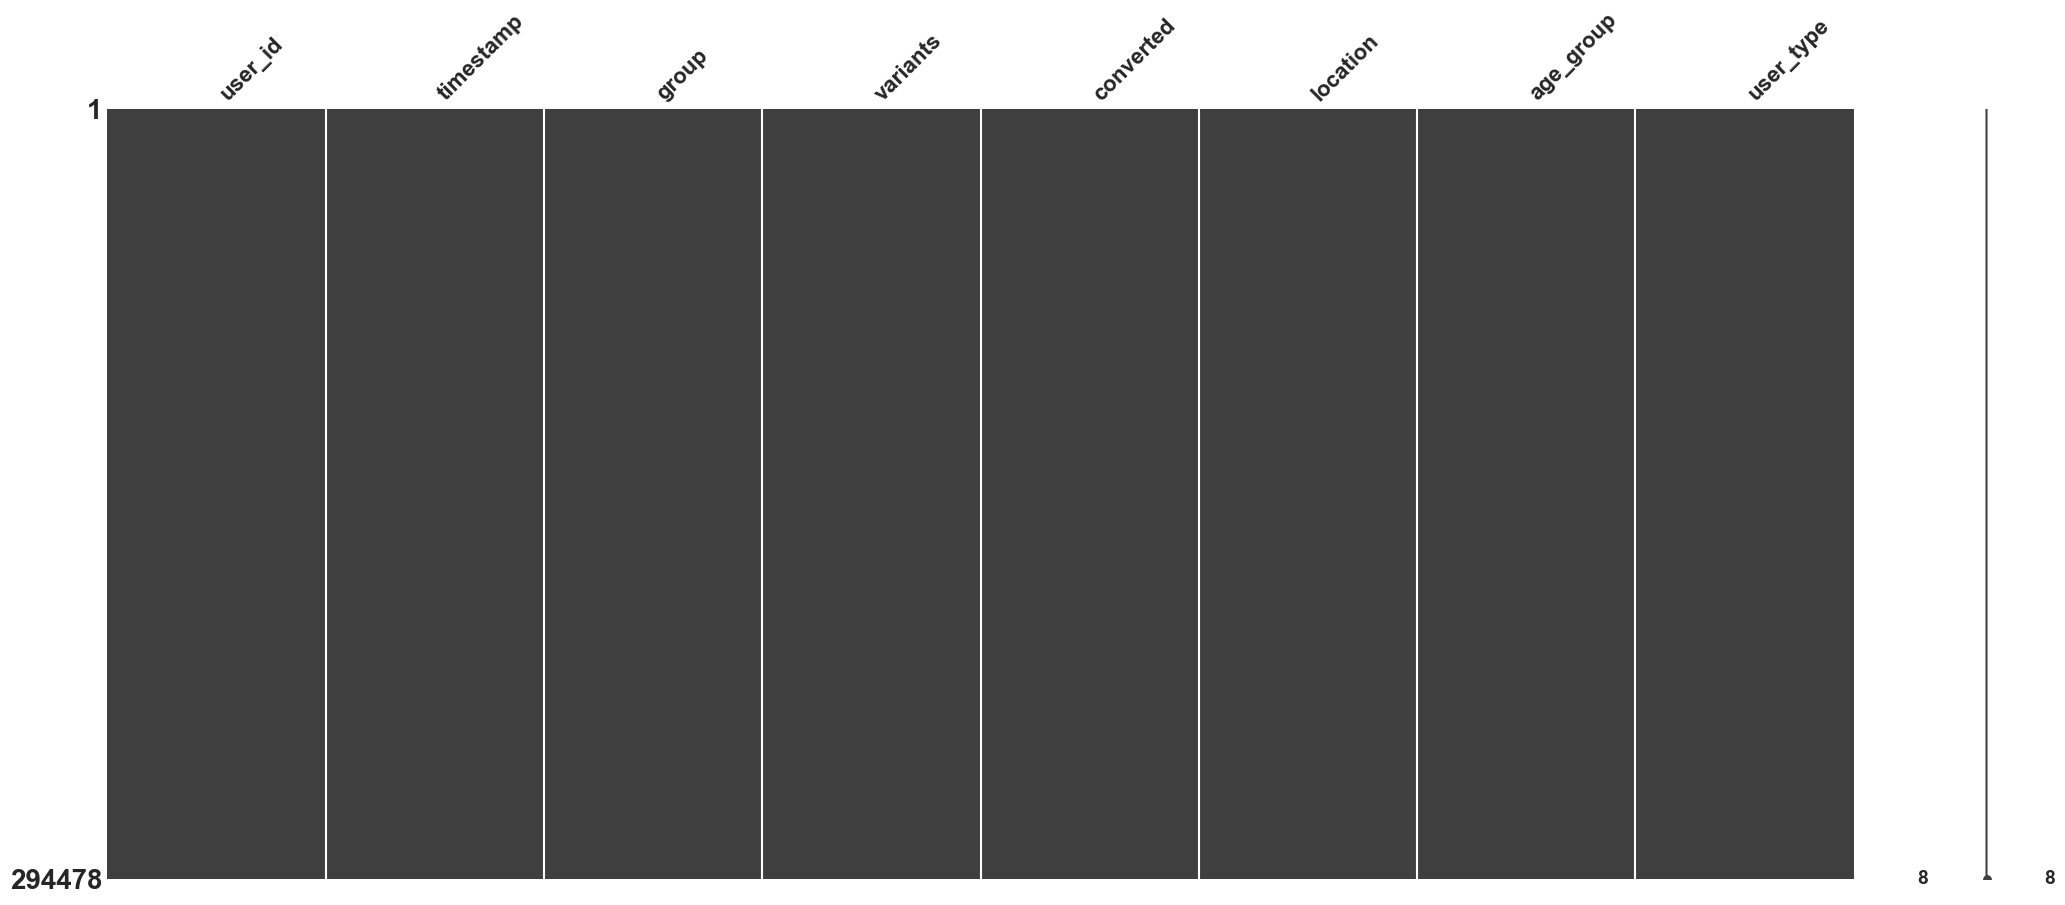

In [450]:
msno.matrix(df)

При сборе данных и формировании датасета возможно дублирование строк, что может исказить результаты анализа. Поэтому выполним проверку на отсутствие дубликатов строк.

In [451]:
print(df.duplicated().sum())

0


Кроме того, возможны ситуации, когда один и тот же пользователь осуществил несколько транзакций. Проверка на наличие таких пользователей свидетельствует о том, что такие пользователи отсутствуют.

In [452]:
sessions = df['user_id'].value_counts(ascending=False)
duplicate_users = sessions[sessions > 1].count()
print(duplicate_users)

0


Предварительный анализ данных свидетельствует о том, что датасет пригоден для выполнения основного анализа.

Изучим распределение пользователей по группам (control и treatment). Данные свидетельствуют о равномерном распределении.

In [453]:
df.group.value_counts(normalize=True)

group
treatment    0.500126
control      0.499874
Name: proportion, dtype: float64

Изучим данные о конверсии в зависимости от группы пользователей и варианта работы сервиса (в относительных и абсолютных величинах). Данные первой таблицы показывают, что коэффициенты конверсии в каждой группе и подгруппе (в зависимости от варианта работы сервиса) составляют около 12 %. Это позволяет нам сделать предварительное заключение о том, что коэффициенты конверсии не изменяются в зависимости от варианта работы сервиса, но это утверждение следует проверить на основе статистических методов. Кроме того, вторая таблица содержит данные о конверсии в группе treatment при использовании варианта работы сервиса "standard". Эти данные не требуются для проведения А/Б теста (как и данные в группе control при использовании варианта работы сервиса "svm_ensemble_v_1_22"), поэтому они будут исключены из последующего А/Б теста. Однако их можно использовать для проведения А/А теста с целью подтверждения полной идентичности анализируемых групп (control и treatment).

In [454]:
df.groupby(["group", "variants"])["converted"].value_counts(normalize=True).unstack()

converted                             0         1
group     variants                               
control   standard             0.879614  0.120386
          svm_ensemble_v_1_22  0.878631  0.121369
treatment standard             0.872774  0.127226
          svm_ensemble_v_1_22  0.881193  0.118807

In [455]:
df.groupby(["group", "variants"])["converted"].value_counts().unstack()

converted                           0      1
group     variants                          
control   standard             127785  17489
          svm_ensemble_v_1_22    1694    234
treatment standard               1715    250
          svm_ensemble_v_1_22  128047  17264

Построим столбчатую диаграмму для распределения коэффициента конверсии в зависимости от группы (control и treatment) и варианта работы сервиса (standard и svm_ensemble_v_1_22). Поскольку подобные графики будут использоваться и в дальнейшем в данном анализе создадим функцию bar_plot для удобного построения таких диаграмм.

In [456]:
def bar_plot(data, x, y="converted", hue=None, errorbar=None):

    if hue != x and hue != y:
        plt.figure(figsize=(8, 6))
        plt.title(f'Conversion rate by {x} and {hue}')
        plt.ylim(0, 0.17)
        plt.legend(loc='upper right')
    else:
        plt.figure(figsize=(6, 4))
        plt.title(f'Conversion rate by {x}')
        plt.ylim(0, 0.15)

    ax = sns.barplot(data=data, x=x, y=y, hue=hue, errorbar=errorbar)
    plt.ylabel('Conversion rate (%)')

    for i in ax.containers:
        ax.bar_label(i)

    plt.show()

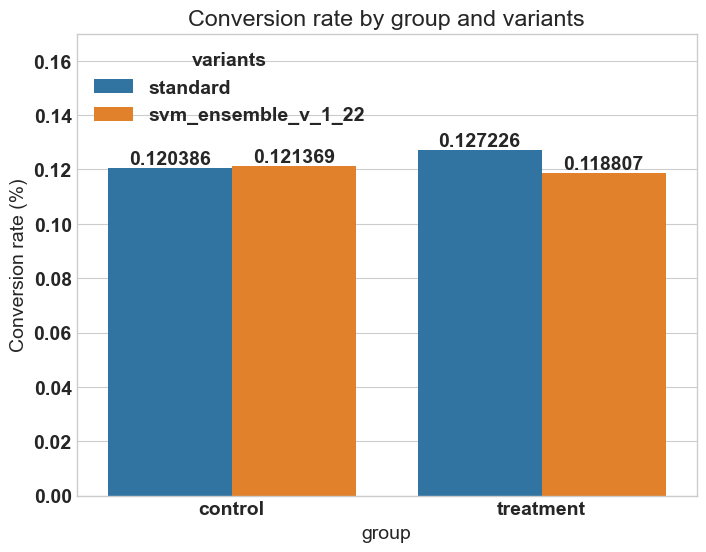

In [457]:
bar_plot(df, x='group', y='converted', hue='variants')

### 1.1 Проведение А/А теста для групп control и treatment

Определим количество пользователей в группе treatment, для которых использовался вариант работы сервиса "standard". Полученный результат (1965) легко проверить с помощью приведенной выше таблицы (1715 + 250 = 1965).

In [458]:
n_obs_aa_test = len(df[(df["group"] == "treatment") & (df["variants"] == "standard")])
n_obs_aa_test

1965

Для проведения А/А теста осуществим выборку пользователей из группы treatment и аналогичную по количеству выборку из группы control, для которых использовали вариант работы сервиса "standard" (df_treatment_aa_test и df_control_aa_test соответственно). Убеждаемся, что в каждой выборке по 1965 пользователей.

In [459]:
df_control_aa_test = df[(df["group"] == "control") & (df["variants"] == "standard")].sample(n=n_obs_aa_test, random_state=13)
df_treatment_aa_test = df[(df["group"] == "treatment") & (df["variants"] == "standard")].sample(n=n_obs_aa_test, random_state=13)
df_control_aa_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1965 entries, 98845 to 80892
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    1965 non-null   object
 1   timestamp  1965 non-null   object
 2   group      1965 non-null   object
 3   variants   1965 non-null   object
 4   converted  1965 non-null   int64 
 5   location   1965 non-null   object
 6   age_group  1965 non-null   object
 7   user_type  1965 non-null   object
dtypes: int64(1), object(7)
memory usage: 138.2+ KB


In [460]:
df_treatment_aa_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1965 entries, 89288 to 47370
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    1965 non-null   object
 1   timestamp  1965 non-null   object
 2   group      1965 non-null   object
 3   variants   1965 non-null   object
 4   converted  1965 non-null   int64 
 5   location   1965 non-null   object
 6   age_group  1965 non-null   object
 7   user_type  1965 non-null   object
dtypes: int64(1), object(7)
memory usage: 138.2+ KB


Определим коэффициенты конверсии для каждой группы (control и treatment). Они составляют 11,9 % и 12,7 % соответственно.

In [461]:
print(df_control_aa_test["converted"].value_counts(normalize=True))
print(df_treatment_aa_test["converted"].value_counts(normalize=True))

converted
0    0.880916
1    0.119084
Name: proportion, dtype: float64
converted
0    0.872774
1    0.127226
Name: proportion, dtype: float64


Для подтверждения идентичности групп control и treatment необходимо с помощью статистических методов убедиться, что значения коэффициента конверсии для этих групп не отличаются друг от друга со статистической достоверностью.
Выдвиним нулевую гипотезу Н_0 о том, что значения коэффициента конверсии в обеих группах равны, а также альтернативную гипотезу Н_1 о том, что они не равны. Примем альфа = 0,05.

In [462]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

def AA_AB_test(control_results, treatment_results, alpha=0.05):
    n_contr = control_results.count()
    n_treat = treatment_results.count()
    successes = [control_results.sum(), treatment_results.sum()]
    nobs = [n_contr, n_treat]

    z_stat, pval = proportions_ztest(successes, nobs=nobs)
    (lower_contr, lower_treat), (upper_contr, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=alpha)

    return f'Z-statistic: {z_stat:.2f}', f'p-value: {pval:.3f}', f'CI 95% for control group: [{lower_contr:.3f}, {upper_contr:.3f}]', f'CI 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]'

In [463]:
AA_AB_test(df_control_aa_test['converted'], df_treatment_aa_test['converted'])

('Z-statistic: -0.78',
 'p-value: 0.437',
 'CI 95% for control group: [0.105, 0.133]',
 'CI 95% for treatment group: [0.112, 0.142]')

Полученное р-значение (0,437), которое превышает выбранный уровень альфа (0,05), указывает, что мы не можем отклонить нулевую гипотезу и должны вынести заключение о равенстве значений коэффициента конверсии в группах control и treatment при использовании варианта работы сервиса "standard". Т.е. А/А тест подтвердил идентичности групп control и treatment, что позволяет нам провести А/Б тест.

### 1.2 Проведение А/Б теста для групп control и treatment (весь датасет)

Ранее мы отмечали, что в группе treatment пользователи иногда применяли вариант работы сервиса "standard", а в группе control - вариант работы сервиса "svm_ensemble_v_1_22":

In [464]:
df.groupby(["group", "variants"])["converted"].value_counts().unstack()

converted                           0      1
group     variants                          
control   standard             127785  17489
          svm_ensemble_v_1_22    1694    234
treatment standard               1715    250
          svm_ensemble_v_1_22  128047  17264

Эти данные могут исказить результаты А/Б теста (строго говоря, в рассматриваемом нами случае искажения результата, скорее всего, не будет, поскольку коэффициент конверсии в каждой подгруппе практически идентичен, однако в любом ином случае это утверждение может оказаться ложным), поэтому их следует исключить из анализа. Выполним выборку, исключив указанные выше данные и изучим полученный датасет.

In [465]:
df_corr = df[~((df["group"] == "control") & (df["variants"] == "svm_ensemble_v_1_22")) & ~((df["group"] == "treatment") & (df["variants"] == "standard"))]
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290585 entries, 0 to 294477
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    290585 non-null  object
 1   timestamp  290585 non-null  object
 2   group      290585 non-null  object
 3   variants   290585 non-null  object
 4   converted  290585 non-null  int64 
 5   location   290585 non-null  object
 6   age_group  290585 non-null  object
 7   user_type  290585 non-null  object
dtypes: int64(1), object(7)
memory usage: 20.0+ MB


Убедимся, что после устранения искажающих данных пользователи в группах control и treatment использовали только варианты работы сервиса "standard" и "svm_ensemble_v_1_22" соответственно. Кроме того, отметим, что значения коэффициентов конверсии в обеих группах составляют 12 % и 11,9 % соответственно.

In [466]:
print("Конверсия пользователей в зависимости от группы (control или treatment), в относительных величинах:")
df_corr.groupby(["group", "variants"])["converted"].value_counts(normalize=True).unstack()

Конверсия пользователей в зависимости от группы (control или treatment), в относительных величинах:


,converted,0,1
group,variants,,
control,standard,0.879614,0.120386
treatment,svm_ensemble_v_1_22,0.881193,0.118807


Представим эти данные в форме столбчатой диаграммы.

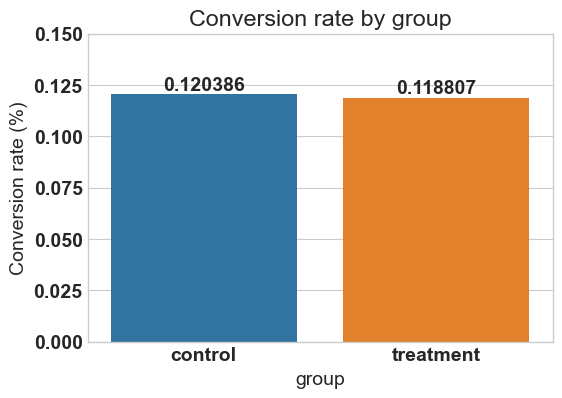

In [467]:
bar_plot(df_corr, x="group", y="converted", hue="group")

В соответствии с условиями задания нам необходимо определить, позволит ли новый вариант работы сервиса увеличить коэффициент конверсии на 2 %. Исходя из приведенных выше данных, в контрольной группе коэффициент конверсии для старого варианта работы сервиса составляет 12 %.
Определим необходимый размер выборки для гарантии того, что при заданном уровне мощности теста (power = 0,8) и уровне значимости (alpha = 0,05) мы сможем обнаружить разность в значениях коэффициента конверсии не менее 2 %. Для этого создадим функцию required_sample, которая в качестве аргументов принимает исходное и целевое значение коэффициента вариации (raw_CR, target_CR), а также значения power, alpha и ratio (соотношение выборок для разных групп)

In [468]:
def required_sample(raw_CR, target_CR, alpha=0.05, power=0.8, ratio=1):
    effect_size = sms.proportion_effectsize(raw_CR, target_CR)
    required_n = sms.NormalIndPower().solve_power(effect_size, power=power, alpha=alpha, ratio=ratio)
    required_n = ceil(required_n)
    return required_n

Рассчитаем необходимый объем выборки для выбранного исходного и целевого значений коэффициента вариации (0,12 и 0,14)

In [469]:
required_sample(0.12, 0.14)

4433

Сформируем соответствующие выборки для группы control и группы treatment, после чего объединим их в один датасет df_ab_test

In [470]:
def ab_dataset(data):
    df_control = data[["group", "converted"]][data['group'] == 'control'].sample(n=required_sample(0.12, 0.14), random_state=13)
    df_treatment = data[["group", "converted"]][data['group'] == 'treatment'].sample(n=required_sample(0.12, 0.14), random_state=13)
    df = pd.concat([df_control, df_treatment], axis=0)
    df.reset_index(drop=True, inplace=True)
    return df

In [471]:
df_ab_test = ab_dataset(df_corr)
df_ab_test

,group,converted
0,control,1
1,control,0
2,control,1
3,control,0
4,control,0
...,...,...
8861,treatment,0
8862,treatment,0
8863,treatment,0
8864,treatment,1


При изучении датасета df_ab_test отмечаем, что количество строк в датасете составляет 8866, т.е. соответствует удвоенному рассчитанному объему выборки для каждой группы

Как и предполагалось, распределение пользователей между группами control и treatment полностью равномерно.

In [472]:
df_ab_test["group"].value_counts(normalize=True)

group
control      0.5
treatment    0.5
Name: proportion, dtype: float64

Для расчета среднего значения коэффициента конверсии, а также стандартного отклонения и стандартной ошибки создадим функцию conversion_rates, которая в качестве аргументов принимает датасет, группируемый столбец и целевой столбец, для которого следует провести расчет

In [473]:
def conversion_rates(data, group_column:str, target_column:str):
    conversion_rates = data.groupby(group_column)[target_column]
    std_proportion = lambda x: np.std(x, ddof=0)
    se_proportion = lambda x: stats.sem(x, ddof=0)

    conversion_rates = conversion_rates.agg(["mean", std_proportion, se_proportion]).rename(columns={'mean':'CR mean', '<lambda_0>':'CR std', '<lambda_1>':'CR se'})
    
    return conversion_rates

Исходя из представленных ниже данных, статистики коэффициента конверсии в группах control и treatment практически идентичны.

In [474]:
conversion_rates(df_ab_test, "group", "converted")

,CR mean,CR std,CR se
group,,,
control,0.115949,0.320163,0.004809
treatment,0.119107,0.323914,0.004865


Графическое представление данных о среднем значении коэффициента конверсии для групп control и treatment

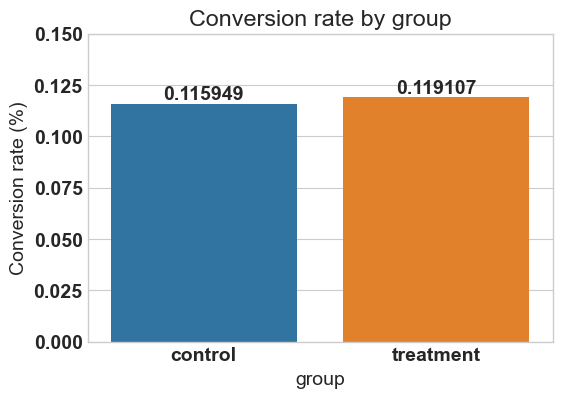

In [475]:
bar_plot(df_ab_test, x='group', y='converted', hue='group')

Для подтверждения предварительного заключения о равенстве средних значений коэффициента конверсии в группах control и treatment проведем А/Б тест, используя для этого функцию AA_AB_test и данные из датасета df_ab_test. Нулевая гипотеза Н_0 будет гласить о равенстве средних значений в обеих группах, а альтернативная гипотеза Н_1 - об их неравенстве. Уровень значимости альфа примем равным 0,05.

In [476]:
AA_AB_test(df_ab_test[df_ab_test['group'] == 'control']['converted'], df_ab_test[df_ab_test['group'] == 'treatment']['converted'])

('Z-statistic: -0.46',
 'p-value: 0.644',
 'CI 95% for control group: [0.107, 0.125]',
 'CI 95% for treatment group: [0.110, 0.129]')

Полученное р-значение (0,644), которое превышает выбранный уровень альфа (0,05), указывает, что мы не можем отклонить нулевую гипотезу и должны вынести заключение о равенстве значений коэффициента конверсии в группах control и treatment при использовании варианта работы сервиса "standard" и "svm_ensemble_v_1_22" соответственно, т.е. новый вариант работы сервиса не приводит к увеличению коэффициента конверсии.

# Решение задания 2. Стоит ли для новых/старых пользователей (new/registered user) оставить старый/новый вариант работы?

### 2.1 Проведение А/А теста для групп control и treatment среди новых пользователей (new_user)

Как и для полного датасета, отмечаем, что для пользователей new_user группа treatment также использовали вариант работы сервиса "standard" (871 + 135 = 1006 пользователей), хотя основной целью А/Б теста было использование в этой группе варианта "svm_ensemble_v_1_22". Данные, полученные для варианта работы сервиса "standard" среди новых пользователей в группе treatment, оказываются полезными для проведения А/А теста.

In [477]:
df.groupby(["user_type", "group", "variants"])["converted"].value_counts().unstack()

converted                                          0     1
user_type       group     variants                        
new_user        control   standard             63991  8800
                          svm_ensemble_v_1_22    854   105
                treatment standard               871   135
                          svm_ensemble_v_1_22  63978  8504
registered_user control   standard             63794  8689
                          svm_ensemble_v_1_22    840   129
                treatment standard               844   115
                          svm_ensemble_v_1_22  64069  8760

Для проведения А/А теста осуществим выборку новых пользователей (new_user) для группы treatment и аналогичную по количеству выборку новых пользователей для группы control, для которых использовали вариант работы сервиса "standard" (df_new_user_treatment_aa_test и df_new_user_control_aa_test соответственно). Убеждаемся, что в каждой выборке по 1006 пользователей.

In [478]:
n_obs_new_user_aa_test = len(df[(df["user_type"] == "new_user") & (df["group"] == "treatment") & (df["variants"] == "standard")])
n_obs_new_user_aa_test

1006

In [479]:
df_new_user_control_aa_test = df[(df["user_type"] == "new_user") & (df["group"] == "control") & (df["variants"] == "standard")].sample(n=n_obs_new_user_aa_test, random_state=13)
df_new_user_treatment_aa_test = df[(df["user_type"] == "new_user") & (df["group"] == "treatment") & (df["variants"] == "standard")].sample(n=n_obs_new_user_aa_test, random_state=13)
df_new_user_control_aa_test.shape

(1006, 8)

In [480]:
df_new_user_treatment_aa_test.shape

(1006, 8)

Определим коэффициенты конверсии для каждой группы (control и treatment) среди новых пользователей. Они составляют 12,5 % и 13,4 % соответственно.

In [481]:
print(df_new_user_control_aa_test["converted"].value_counts(normalize=True))
print(df_new_user_treatment_aa_test["converted"].value_counts(normalize=True))

converted
0    0.874751
1    0.125249
Name: proportion, dtype: float64
converted
0    0.865805
1    0.134195
Name: proportion, dtype: float64


Для подтверждения идентичности групп control и treatment среди новых пользователей необходимо с помощью статистических методов убедиться, что значения коэффициента конверсии для этих групп не отличаются друг от друга со статистической достоверностью.
Выдвинем нулевую гипотезу Н_0 о том, что значения коэффициента конверсии в обеих группах равны, а также альтернативную гипотезу Н_1 о том, что они не равны. Примем альфа = 0,05.

In [482]:
AA_AB_test(df_new_user_control_aa_test['converted'], df_new_user_treatment_aa_test['converted'])

('Z-statistic: -0.60',
 'p-value: 0.550',
 'CI 95% for control group: [0.105, 0.146]',
 'CI 95% for treatment group: [0.113, 0.155]')

Полученное р-значение (0,550), которое превышает выбранный уровень альфа (0,05), указывает, что мы не можем отклонить нулевую гипотезу и должны вынести заключение о равенстве значений коэффициента конверсии в группах control и treatment среди новых пользователей при использовании варианта работы сервиса "standard". Т.е. А/А тест подтвердил идентичности групп control и treatment новых пользователей, что позволяет нам провести А/Б тест.

### 2.2 Проведение А/Б теста для новых пользователей (new_user)

Определим значения коэффициента конверсии в разных подгруппах в зависимости от группы пользователей (control/treatment) и типа пользователей (user_type). Как видим, значения коэффициента конверсии в каждой подгруппе равны около 12 %.

In [501]:
df_corr.groupby(['user_type', "group", "variants"])["converted"].value_counts(normalize=True).unstack()

converted                                             0         1
user_type       group     variants                               
new_user        control   standard             0.879106  0.120894
                treatment svm_ensemble_v_1_22  0.882674  0.117326
registered_user control   standard             0.880124  0.119876
                treatment svm_ensemble_v_1_22  0.879718  0.120282

Графическое представление приведенных выше данных

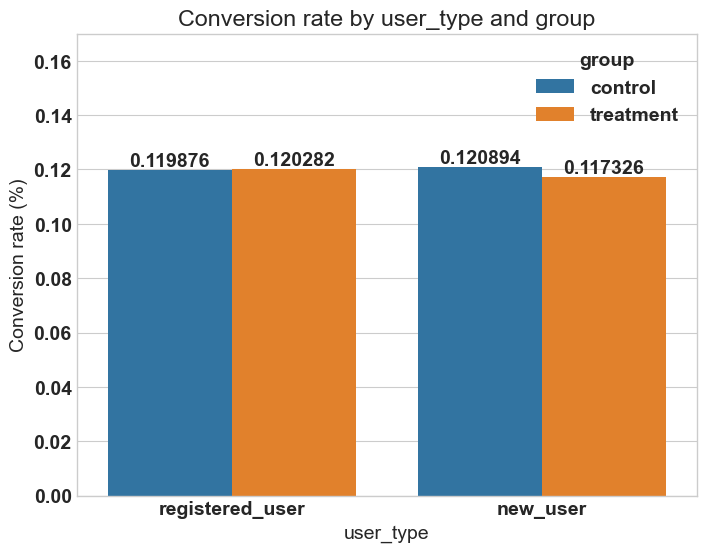

In [484]:
bar_plot(df_corr, x='user_type', y='converted', hue='group')

Выберем данные, относящиеся к новым пользователям (new_user), и сформируем датасет df_new_user. Изучим значения коэффициентов конверсии в подгруппах control и treatment. Данные свидетельствуют о том, что значения коэффициентов конверсии составляют 12,1 % и 11,7 % соответственно.

In [485]:
df_new_user = df_corr[df_corr['user_type'] == 'new_user']
df_new_user.groupby(["user_type", "group"])["converted"].value_counts(normalize=True).unstack()

converted                   0         1
user_type group                        
new_user  control    0.879106  0.120894
          treatment  0.882674  0.117326

Для проверки того, что представленные выше значения коэффициентов конверсии равны, проведем А/Б тестирование.
Сформируем выборку для проведения А/Б теста, объем которой соответствует рассчитанному выше (по 4433 пользователей из каждой группы control и treatment).

In [486]:
df_new_user_ab_test = ab_dataset(df_new_user)
df_new_user_ab_test

,group,converted
0,control,0
1,control,0
2,control,1
3,control,1
4,control,1
...,...,...
8861,treatment,0
8862,treatment,0
8863,treatment,0
8864,treatment,0


Рассчитаем статистические характеристики для каждой группы (control и treatment) в сформированной выборке новых пользователей

In [487]:
conversion_rates(df_new_user_ab_test, "group", "converted")

,CR mean,CR std,CR se
group,,,
control,0.119107,0.323914,0.004865
treatment,0.114595,0.318533,0.004784


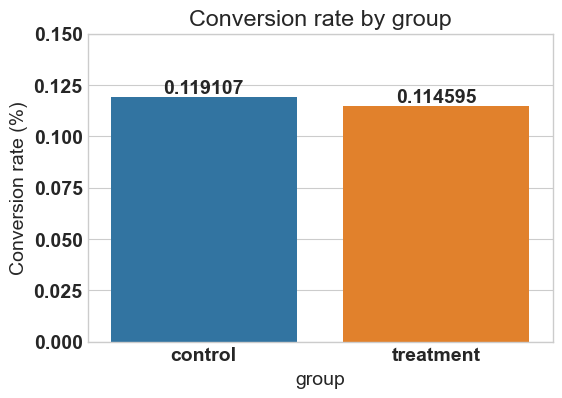

In [488]:
bar_plot(df_new_user_ab_test, x='group', y='converted', hue='group')

Проведем А/Б тест, используя датасет df_new_user_ab_test и функцию АА_AB_test. В качестве нулевой гипотезы Н_0 примем, что средние значения коэффициентов вариации равны, а в качестве альтернативной гипотезы Н_1 - то, что они не равны. Уровень значимости альфа примем равным 0,05.

In [489]:
AA_AB_test(df_new_user_ab_test[df_new_user_ab_test['group'] == 'control']['converted'], df_new_user_ab_test[df_new_user_ab_test['group'] == 'treatment']['converted'])

('Z-statistic: 0.66',
 'p-value: 0.508',
 'CI 95% for control group: [0.110, 0.129]',
 'CI 95% for treatment group: [0.105, 0.124]')

Полученное р-значение (0,508), которое превышает выбранный уровень альфа (0,05), указывает, что мы не можем отклонить нулевую гипотезу и должны вынести заключение о равенстве значений коэффициента конверсии в случае новых пользователей (new_user) в группах control и treatment при использовании варианта работы сервиса "standard" и "svm_ensemble_v_1_22" соответственно, т.е. новый вариант работы сервиса не приводит к увеличению коэффициента конверсии среди новых пользователей.

### 2.3 Проведение А/А теста для групп control и treatment среди зарегистрированных пользователей (registered_user)

Как и для полного датасета, отмечаем, что для зарегистрированных пользователей registered_user в группе treatment также использовали вариант работы сервиса "standard" (844 + 115 = 959 пользователей), хотя основной целью А/Б теста было использование в этой группе варианта "svm_ensemble_v_1_22". Данные, полученные для варианта работы сервиса "standard" среди зарегистрированных пользователей в группе treatment, оказываются полезными для проведения А/А теста.

In [490]:
df.groupby(["user_type", "group", "variants"])["converted"].value_counts().unstack()

converted                                          0     1
user_type       group     variants                        
new_user        control   standard             63991  8800
                          svm_ensemble_v_1_22    854   105
                treatment standard               871   135
                          svm_ensemble_v_1_22  63978  8504
registered_user control   standard             63794  8689
                          svm_ensemble_v_1_22    840   129
                treatment standard               844   115
                          svm_ensemble_v_1_22  64069  8760

Для проведения А/А теста осуществим выборку зарегистрированных пользователей (registered_user) для группы treatment и аналогичную по количеству выборку зарегистрированных пользователей для группы control, для которых использовали вариант работы сервиса "standard" (df_reg_user_treatment_aa_test и df_reg_user_control_aa_test соответственно). Убеждаемся, что в каждой выборке по 959 пользователей.

In [491]:
n_obs_reg_user_aa_test = len(df[(df["user_type"] == "registered_user") & (df["group"] == "treatment") & (df["variants"] == "standard")])
n_obs_reg_user_aa_test

959

In [492]:
df_reg_user_control_aa_test = df[(df["user_type"] == "registered_user") & (df["group"] == "control") & (df["variants"] == "standard")].sample(n=n_obs_reg_user_aa_test, random_state=13)
df_reg_user_treatment_aa_test = df[(df["user_type"] == "registered_user") & (df["group"] == "treatment") & (df["variants"] == "standard")].sample(n=n_obs_reg_user_aa_test, random_state=13)
df_reg_user_control_aa_test.shape

(959, 8)

In [493]:
df_reg_user_treatment_aa_test.shape

(959, 8)

Определим коэффициенты конверсии для каждой группы (control и treatment) среди зарегистрированных пользователей. Они составляют 12,1 % и 12,0 % соответственно.

In [494]:
print(df_reg_user_control_aa_test["converted"].value_counts(normalize=True))
print(df_reg_user_treatment_aa_test["converted"].value_counts(normalize=True))

converted
0    0.879041
1    0.120959
Name: proportion, dtype: float64
converted
0    0.880083
1    0.119917
Name: proportion, dtype: float64


Для подтверждения идентичности групп control и treatment среди зарегистрированных пользователей необходимо с помощью статистических методов убедиться, что значения коэффициента конверсии для этих групп не отличаются друг от друга со статистической достоверностью.
Выдвинем нулевую гипотезу Н_0 о том, что значения коэффициента конверсии в обеих группах равны, а также альтернативную гипотезу Н_1 о том, что они не равны. Примем альфа = 0,05.

In [495]:
AA_AB_test(df_reg_user_control_aa_test['converted'], df_reg_user_treatment_aa_test['converted'])

('Z-statistic: 0.07',
 'p-value: 0.944',
 'CI 95% for control group: [0.100, 0.142]',
 'CI 95% for treatment group: [0.099, 0.140]')

Полученное значение р-значения (0,944), которое превышает выбранный уровень альфа (0,05), указывает, что мы не можем отклонить нулевую гипотезу и должны вынести заключение о равенстве значений коэффициента конверсии в группах control и treatment среди зарегистрированных пользователей при использовании варианта работы сервиса "standard". Т.е. А/А тест подтвердил идентичности групп control и treatment среди зарегистрированных пользователей, что позволяет нам провести А/Б тест.

### 2.4 Проведение А/Б теста для зарегистрированных пользователей пользователей (registered_user)

Выберем данные, относящиеся к зарегистрированным пользователям (registered_user), и сформируем датасет df_reg_user. Изучим значения коэффициентов конверсии в подгруппах control и treatment. Данные свидетельствуют о том, что значения коэффициентов конверсии составляют 12 % соответственно.

In [496]:
df_reg_user = df_corr[df_corr['user_type'] == 'registered_user']
df_reg_user.groupby(["user_type", "group"])["converted"].value_counts(normalize=True).unstack()

converted                         0         1
user_type       group                        
registered_user control    0.880124  0.119876
                treatment  0.879718  0.120282

Для проверки того, что представленные выше значения коэффициентов конверсии равны, проведем А/Б тестирование. Сформируем выборку для проведения А/Б теста, объем которой соответствует рассчитанному выше (по 4433 пользователей из каждой группы control и treatment).

In [497]:
df_reg_user_ab_test = ab_dataset(df_reg_user)
df_reg_user_ab_test

,group,converted
0,control,0
1,control,0
2,control,0
3,control,1
4,control,0
...,...,...
8861,treatment,0
8862,treatment,0
8863,treatment,0
8864,treatment,0


Рассчитаем статистические характеристики для каждой группы (control и treatment) в сформированной выборке зарегистрированных пользователей

In [498]:
conversion_rates(df_reg_user_ab_test, "group", "converted")

,CR mean,CR std,CR se
group,,,
control,0.118204,0.322850,0.004849
treatment,0.117979,0.322583,0.004845


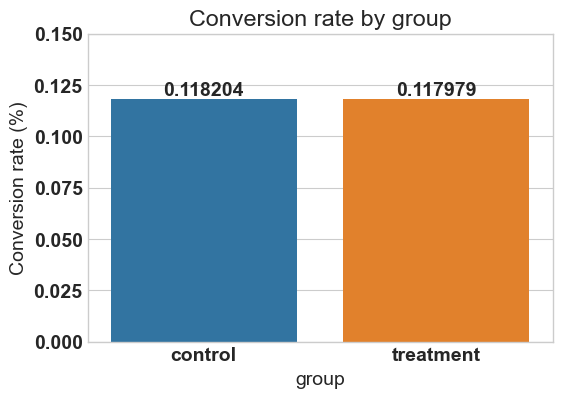

In [499]:
bar_plot(df_reg_user_ab_test, x='group', y='converted', hue='group')

Проведем А/Б тест, используя датасет df_reg_user_ab_test и функцию АА_AB_test. В качестве нулевой гипотезы Н_0 примем, что средние значения коэффициентов вариации равны, а в качестве альтернативной гипотезы Н_1 - то, что они не равны. Уровень значимости альфа примем равным 0,05.

In [500]:
AA_AB_test(df_reg_user_ab_test[df_reg_user_ab_test['group'] == 'control']['converted'], df_reg_user_ab_test[df_reg_user_ab_test['group'] == 'treatment']['converted'])

('Z-statistic: 0.03',
 'p-value: 0.974',
 'CI 95% for control group: [0.109, 0.128]',
 'CI 95% for treatment group: [0.108, 0.127]')

Полученное значение р-значения (0,974), которое превышает выбранный уровень альфа (0,05), указывает, что мы не можем отклонить нулевую гипотезу и должны вынести заключение о равенстве значений коэффициента конверсии в случае зарегистрированных пользователей (registered_user) в группах control и treatment при использовании варианта работы сервиса "standard" и "svm_ensemble_v_1_22" соответственно, т.е. новый вариант работы сервиса не приводит к увеличению коэффициента конверсии среди зарегистрированных пользователей.

#### Заключение: по результатам А/А теста установлено, что группы control и treatment для всего датасета и для отдельных подгрупп (новые и уже зарегистрированные пользователи) являются сбалансированными и идентичными. Поэтому проведение А/Б теста правомерно. По результатам А/Б теста для всего датасета и в отдельных подгруппах (новые и уже зарегистрированные пользователи) показано, что новый вариант работы сервиса "svm_ensemble_v_1_22" не позволяет добиться 2 % улучшения коэффициента конверсии в сравнении со стандартным вариантом работы сервиса.